# Held et al. two-layer RCMIP

Here we perform the Held et al. two-layer model runs for RCMIP. This notebook shows how the OpenSCM library should 'feel' to the end user. We're not at that point yet and will need a major re-write to get it workable, but this at least shows where we're going.

## Imports

In [73]:
import datetime as dt
import json
import os.path

import numpy as np
import pandas as pd
import pyam
import tqdm.notebook
from scmdata import df_append, ScmDataFrame

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [74]:
F2X_CO2 = 3.74  # W / m^2

## Models

In [75]:
class HeldTwoLayerModel():
    """
    Quick implementation of Held two layer model (Held et al. 2010)
    including state dependent feedback factor.
    
    Based on:
    
    C dT/dt = F + (\\lambda_0 + b T) T - \\epsilon \\eta (T - T_D)
    
    C_D dT_D/dt = \\eta (T - T_D)
    
    where C is heat capacity of upper ocean (J K^-1 m^-2), C_D is heat capacity
    of deep ocean, T is temperature change of upper ocean (K), T_D is 
    temperature change of deep ocean, \\lambda_0 is initial
    feedback factor (W m^-2 K^-1), b is state dependent feedback term (W m^-2 K^-2),
    \\epsilon is efficacy factor for ocean heat uptake (dimensionless)
    and \\eta is heat transport efficiency (W m^-2 K^-1).
    
    Inputs should all be on an annual timestep (no checks are done for
    this...).
    
    If you're used to the energy balance model, 
    
    F = \\lambda T + dH/dt
    
    then be careful, the sign of \\lambda follows the opposite convention
    here i.e. \\lambda is negative.
    """

    name = "held_two_layer_model"

    C = (
        1000  # density of water (kg m^-3)
        * 4181  # heat capacity of water (J K^-1 kg^-1)
        * 50  # depth of upper layer (m)
    )
    C_D = (
        1000  # density of water (kg m^-3)
        * 4181  # heat capacity of water (J K^-1 kg^-1)
        * 1200  # depth of lower layer (m)
    )
    lambda_0 = -F2X_CO2 / 3  # forcing due to doubling of CO2 (W m^-2)  # ECS (K)
    b = 0.0  # (W m^-2 K^-2)
    epsilon = 1.0
    eta = 0.8  # (W m^-2 K^-1)
    f_scaling = 1.0
    
    def __init__(self):
        pass

    def run(self, inputs, run_params, outputs=None):
        """
        inputs : scmdata.ScmDataFrame
        
        run_params : dict
        """
        for kwarg, value in run_params.items():
            setattr(self, kwarg, value)
            
        effrf_scmdf = inputs.filter(
            variable="Effective Radiative Forcing",
            region="World",
            unit="W/m\^2",
        )
        
        self.effrf = effrf_scmdf.timeseries().values.squeeze()
        
        scenario = effrf_scmdf.get_unique_meta("scenario", no_duplicates=True)
        model = effrf_scmdf.get_unique_meta("model", no_duplicates=True)
        time = effrf_scmdf["time"]
        timesteps = time[1:].values - time[:-1].values
        # check monthly timesteps
        assert all((timesteps > dt.timedelta(days=27)) & (timesteps < dt.timedelta(days=32)))

        self.calculate_temperatures()
        
        effective_climate_feedback = (
            (self.effrf - self.rndt) / self.temperatures_upper
        )
        effective_climate_sensitivity = (
            F2X_CO2 / effective_climate_feedback
        )
        lambda_model = (self.lambda_0 + (self.b * self.temperatures_upper))

        out = ScmDataFrame(
            pd.DataFrame(
                np.vstack(
                    [
                        self.temperatures_upper,
                        self.temperatures_lower,
                        self.effrf,
                        self.rndt,
                        effective_climate_feedback,
                        lambda_model,
                        effective_climate_sensitivity,
                    ]
                ).T,
                index=time,
            ),
            columns={
                "unit": ["K", "K", "W/m^2", "W/m^2", "W/m^2/K", "W/m^2/K", "K"],
                "variable": [
                    "Surface Temperature",
                    "Deep Ocean Temperature",
                    "Effective Radiative Forcing",
                    "Net Top of Atmosphere Energy Imbalance",
                    "Effective Climate Feedback",
                    "lambda_model",
                    "Effective Climate Sensitivity",
                ],
                "region": ["World"],
                "model": [self.name],
                "scenario": ["unspecified"],
            },
        )
        
        
        out.set_meta(self.name, "climatemodel")
        out.set_meta(scenario, "scenario")
        out.set_meta(model, "model")

        return out

    def calculate_temperatures(self):
        delta_time = 60 * 60 * 24 * 30  # assume 30 day month...

        temp_upper = np.nan * np.zeros_like(self.effrf)
        temp_lower = np.nan * np.zeros_like(self.effrf)
        rndt = np.nan * np.zeros_like(self.effrf)

        temp_upper[0] = 0.0
        temp_lower[0] = 0.0
        rndt[0] = 0.0

        for i in range(temp_upper.shape[0] - 1):
            exchange_term_raw = self.eta * (temp_upper[i] - temp_lower[i])

            temp_upper[i + 1] = (
                temp_upper[i]
                + delta_time
                * (
                    self.effrf[i]
                    + (self.lambda_0 + self.b * temp_upper[i]) * temp_upper[i]
                    - (self.epsilon * exchange_term_raw)
                )
                / self.C
            )

            temp_lower[i + 1] = temp_lower[i] + (
                delta_time * exchange_term_raw / self.C
            )

            rndt[i + 1] = (
                self.C * (temp_upper[i + 1] - temp_upper[i])
                + self.C_D * (temp_lower[i + 1] - temp_lower[i])
            ) / delta_time

        self.temperatures_upper = temp_upper
        self.temperatures_lower = temp_lower
        self.rndt = rndt

## RCMIP data

In [76]:
RCMIP_TEMP_OBS_FILE = os.path.join(
    "rcmip-observations_observations-priestley-centre_world_surface-air-temperature-change.csv"
)
rcmip_obs = df_append([RCMIP_TEMP_OBS_FILE])

INFO:scmdata.dataframe:Reading rcmip-observations_observations-priestley-centre_world_surface-air-temperature-change.csv


In [77]:
RCMIP_CONCS_FILE = os.path.join(
    "rcmip-concentrations-annual-means-v3-1-0.csv"
)

In [78]:
rcmip_data_raw = df_append([RCMIP_CONCS_FILE])
rcmip_data_raw.head()

INFO:scmdata.dataframe:Reading rcmip-concentrations-annual-means-v3-1-0.csv


time                                                                                       1700-01-01 00:00:00  \
model       scenario       region variable                       unit activity_id mip_era                        
unspecified 1pctCO2        World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            1pctCO2-4xext  World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-0p5xCO2 World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-2xCO2   World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-4xCO2   World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   

time                                                                                       1701-01-01 00:00:00  \
model       scenario       region variable                       unit activity_id mip_era                        
unspecified 1pctCO2        World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            1pctCO2-4xext  World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-0p5xCO2 World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-2xCO2   World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-4xCO2   World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   

time                                                                                       1702-01-01 00:00:00  \
model       scenario       region variable                       unit activity_id mip_era                        
unspecified 1pctCO2        World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            1pctCO2-4xext  World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-0p5xCO2 World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-2xCO2   World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-4xCO2   World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   

time                                                                                       1703-01-01 00:00:00  \
model       scenario       region variable                       unit activity_id mip_era                        
unspecified 1pctCO2        World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            1pctCO2-4xext  World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-0p5xCO2 World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-2xCO2   World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-4xCO2   World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   

time                                                                                       1704-01-01 00:00:00  \
model       scenario       region variable                       unit activity_id mip_era                        
unspecified 1pctCO2        World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            1pctCO2-4xext  World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-0p5xCO2 World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-2xCO2   World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
            abrupt-4xCO2   World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   

time 

In [79]:
co2_conc_0 = (
    rcmip_data_raw.filter(
        variable="Atmospheric Concentrations|CO2",
        region="World",
        scenario="abrupt-2xCO2",
        year=1900,
    ).values.squeeze()
    / 2
)
co2_conc_0

284.31699879964185

Calculate effective radiative forcing.

In [80]:
def calculate_co2_radiative_forcing(co2_concentrations):
    return (
        F2X_CO2 / np.log(2) * np.log(co2_concentrations / co2_conc_0)
    )

In [81]:
co2_conc_filter = "Atmospheric Concentrations|CO2"
scenario_filter = ["abrupt*", "1pctCO2*", "piControl"]
rcmip_co2_concs = rcmip_data_raw.filter(
    variable=co2_conc_filter, scenario=scenario_filter
).timeseries().unstack("variable").stack("time")

rcmip_co2_concs["Effective Radiative Forcing"] = calculate_co2_radiative_forcing(
    rcmip_co2_concs[co2_conc_filter] 
)
rcmip_co2_concs = rcmip_co2_concs.unstack("time").stack("variable").reset_index()
rcmip_co2_concs.loc[
    rcmip_co2_concs["variable"] == "Effective Radiative Forcing",
    "unit"
] = "W/m^2"

rcmip_data = ScmDataFrame(rcmip_co2_concs)
rcmip_data.head()

time                                                                                                     1850-01-01 00:00:00  \
model       scenario region                    variable                       unit  activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             284.316999   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.000000   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             284.329140   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.000230   
                     World|Southern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             284.304863   

time                                                                                                     1851-01-01 00:00:00  \
model       scenario region                    variable                       unit  activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             287.160169   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.053689   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             287.172431   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.053919   
                     World|Southern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             287.147912   

time                                                                                                     1852-01-01 00:00:00  \
model       scenario region                    variable                       unit  activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             290.031770   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.107378   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             290.044155   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.107608   
                     World|Southern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             290.019391   

time                                                                                                     1853-01-01 00:00:00  \
model       scenario region                    variable                       unit  activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             292.932088   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.161066   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             292.944597   
                                               Effective Radiative Forcing    W/m^2 input4MIPs  CMIP6               0.161297   
                     World|Southern Hemisphere Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             292.919585   

time                                                                                                     1854-01-01 00:00:00  \
model       scenario region                    variable                       unit  activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CO2 ppm   input4MIPs  CMIP6             295.861409   
                            

Add historical and ssp timeseries.

In [82]:
RCMIP_RF_FILE = os.path.join(
    "rcmip-radiative-forcing-annual-means-v3-1-0.csv"
)

rcmip_data = rcmip_data.append(ScmDataFrame(RCMIP_RF_FILE).filter(
    scenario=["historical", "ssp*"],
    variable="Effective Radiative Forcing"
))

INFO:scmdata.dataframe:Reading rcmip-radiative-forcing-annual-means-v3-1-0.csv


Interpolate onto monthly timesteps.

In [83]:
rcmip_effrf = rcmip_data.filter(variable="Effective Radiative Forcing").interpolate(
    [dt.datetime(y, m, 1) for y in range(1850, 2501) for m in range(1, 13)]
)

In [84]:
rcmip_effrf.head()

time                                                                                     1850-01-01 00:00:00  \
model       scenario       region variable                    unit  activity_id mip_era                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                    NaN   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                    NaN   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                    NaN   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                    NaN   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                    NaN   

time                                                                                     1850-02-01 00:00:00  \
model       scenario       region variable                    unit  activity_id mip_era                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00456   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                0.00456   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               -3.74000   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                3.74000   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6                7.48000   

time                                                                                     1850-03-01 00:00:00  \
model       scenario       region variable                    unit  activity_id mip_era                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.008678   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.008678   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6              -3.740000   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               3.740000   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               7.480000   

time                                                                                     1850-04-01 00:00:00  \
model       scenario       region variable                    unit  activity_id mip_era                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.013238   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.013238   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6              -3.740000   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               3.740000   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               7.480000   

time                                                                                     1850-05-01 00:00:00  \
model       scenario       region variable                    unit  activity_id mip_era                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.017651   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               0.017651   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6              -3.740000   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               3.740000   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 input4MIPs  CMIP6               7.480000   

time                                                                       

INFO:root:>=13 labels, not applying legend


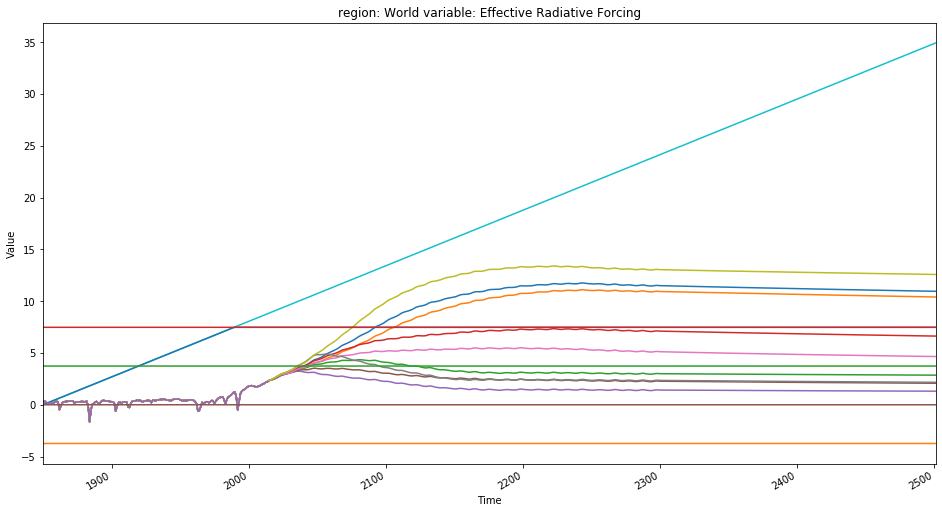

In [85]:
rcmip_effrf.filter(region="World").line_plot(color="scenario", figsize=(16, 9))

## Run

In [86]:
with open("held-two-layer-cfgs.json", "r") as fh:
    held_two_layer_cfgs = json.load(fh)
    
held_two_layer_cfgs[:2]

[{'descr': 'Held two-layer model with state-dependent feedback factor implementation with ECS=3K adjusted to give moderate agreement with historical observations',
  'name': 'held-two-layer-uom-ECS-3K',
  'parameter_values': {'C': 209050000,
   'C_D': 5017200000,
   'b': 0.05,
   'epsilon': 2.0,
   'eta': 0.9,
   'lambda_0': -1.397}},
 {'descr': 'Held two-layer model with state-dependent feedback factor implementation calibrated to the idealised CO2-only experiments for the r1i1p1f1 variant of the BCC-CSM2-MR model',
  'name': 'held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB',
  'parameter_values': {'C': 93559645.58031182,
   'C_D': 1829168324.6738226,
   'b': -0.0036624992393419643,
   'epsilon': 10.959704053777843,
   'eta': 0.09659984859140298,
   'lambda_0': -1.411520803450022}}]

In [87]:
def calculate_ecs(lambda_0, b, f2x):
    return (-lambda_0 - ((lambda_0 ** 2 - (4 * f2x * b)) ** 0.5)) / (2 * b)

Runs with default setup.

In [88]:
scenarios_to_run = [
    "abrupt*",
    "1pctCO2*",
    "piControl*",
    "historical",
    "ssp*",
]
runners_cfgs = {
    HeldTwoLayerModel: [c for c in held_two_layer_cfgs if "ECS-3K" in c["name"]], 
}

results_default = []
for model, cfgs in tqdm.notebook.tqdm(runners_cfgs.items(), desc="Model"):
    runner = model()
    runner.co2_pi = co2_conc_0
    startyear=1750
    endyear=2500
    scens_to_run = rcmip_effrf.filter(
        mip_era="CMIP6"  # we don't have ERF for CMIP5 stuff...
    )["scenario"].unique()
    for scenario in tqdm.notebook.tqdm(scens_to_run, desc="scenarios", leave=False):
        run_df = rcmip_effrf.filter(scenario=scenario, year=range(startyear, endyear+1))
        for cfg in tqdm.notebook.tqdm(cfgs, desc="configs", leave=False):
            pvs = cfg["parameter_values"]
            res_run = runner.run(run_df, pvs)
            res_run.set_meta(cfg["name"], "climatemodel")
            
            boxes = len([k for k in pvs if k.startswith("c")])
            ecs = calculate_ecs(pvs["lambda_0"], pvs["b"], F2X_CO2)
            res_run.set_meta(ecs, "ECS (K)")
            
            results_default.append(res_run)
            
results_default = df_append(results_default)

/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: overflow encountered in double_scalars
/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in double_scalars
/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide


In [89]:
df_append(
    [results_default, rcmip_obs]
).filter(scenario="historical", variable="*Temperature*").head()

time                                                                                                        1850-01-01  \
model       scenario   region variable                       unit ECS (K)  climatemodel                                  
unspecified historical World  Deep Ocean Temperature         K    2.999088 held-two-layer-uom-ECS-3K          0.000000   
                              Surface Air Temperature Change K    NaN      Observations (Priestley Centre)   -0.042412   
                              Surface Temperature            K    2.999088 held-two-layer-uom-ECS-3K          0.000000   

time                                                                                                        1850-02-01  \
model       scenario   region variable                       unit ECS (K)  climatemodel                                  
unspecified historical World  Deep Ocean Temperature         K    2.999088 held-two-layer-uom-ECS-3K          0.000000   
                              Surface Air Temperature Change K    NaN      Observations (Priestley Centre)         NaN   
                              Surface Temperature            K    2.999088 held-two-layer-uom-ECS-3K          0.003854   

time                                                                                                        1850-03-01  \
model       scenario   region variable                       unit ECS (K)  climatemodel                                  
unspecified historical World  Deep Ocean Temperature         K    2.999088 held-two-layer-uom-ECS-3K          0.000043   
                              Surface Air Temperature Change K    NaN      Observations (Priestley Centre)         NaN   
                              Surface Temperature            K    2.999088 held-two-layer-uom-ECS-3K          0.007556   

time                                                                                                        1850-04-01  \
model       scenario   region variable                       unit ECS (K)  climatemodel                                  
unspecified historical World  Deep Ocean Temperature         K    2.999088 held-two-layer-uom-ECS-3K          0.000127   
                              Surface Air Temperature Change K    NaN      Observations (Priestley Centre)         NaN   
                              Surface Temperature            K    2.999088 held-two-layer-uom-ECS-3K          0.011114   

time                                                                                                        1850-05-01  \
model       scenario   region variable                       unit ECS (K)  climatemodel                                  
unspecified historical World  Deep Ocean Temperature         K    2.999088 held-two-layer-uom-ECS-3K          0.000249   
                              Surface Air Temperature Change K    NaN      Observations (Priestley Centre)         NaN   
                              Surface Temperature            K    2.999088 held-two-layer-uom-ECS-3K          0.014535   

time                                                                                                        1850-06-01  \
model       scenario   region variable                       unit ECS (K)  climatemodel                                  
unspecified historical World  Deep Ocean Temperature         K    2.999088 held-two-layer-uom-ECS-3K          0.000409   
                              Surface Air Temperature Change K    NaN      Observations (Priestley Centre)         NaN   
                              Surface Temperature            K    2.999088 held-two-layer-uom-ECS-3K          0.017823   

time                                                                                                        1850-07-01  \
model       scenario   region variable                       unit ECS (K)  climatemodel                                  
unspecified historical World  Deep Ocean Temperature         K    2.999088 held-two-layer-

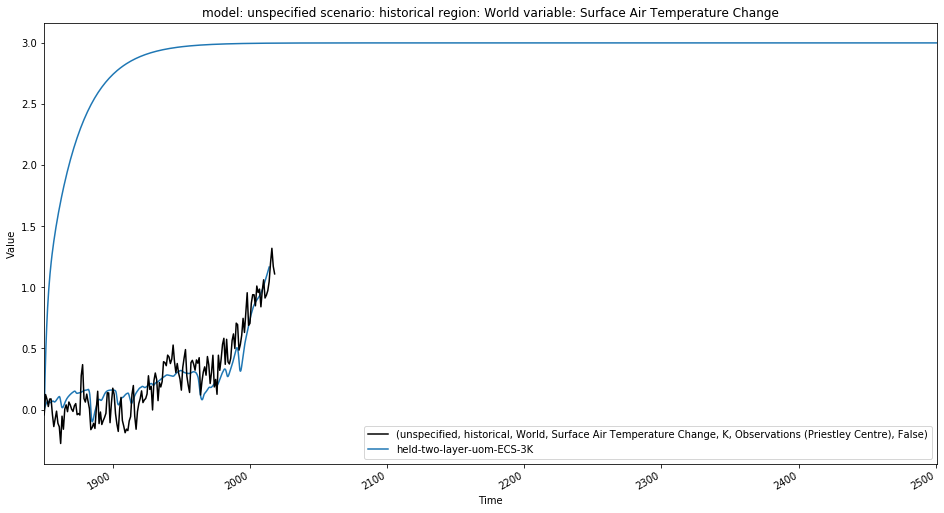

In [91]:
ax = results_default.filter(
    variable=["Surface Temperature", "Surface Air Temperature Change"], 
    scenario=["historical", "abrupt-2xCO2"]
).line_plot(figsize=(16, 9), color="climatemodel")
rcmip_obs.line_plot(figsize=(16, 9), color="black", ax=ax)

In [107]:
scenarios_to_run = [
    "abrupt*",
    "1pctCO2*",
    "piControl*",
]
runners_cfgs = {HeldTwoLayerModel: held_two_layer_cfgs}

results = []
for model, cfgs in tqdm.notebook.tqdm(runners_cfgs.items(), desc="Model"):
    runner = model()
    runner.co2_pi = co2_conc_0
    startyear=1750
    endyear=2500
    scens_to_run = rcmip_effrf.filter(
        scenario=scenarios_to_run, mip_era="CMIP6"  # we don't have ERF for CMIP5 stuff...
    )["scenario"].unique()
    for scenario in tqdm.notebook.tqdm(scens_to_run, desc="scenarios", leave=False):
        run_df = rcmip_effrf.filter(scenario=scenario, year=range(startyear, endyear+1))
        for cfg in tqdm.notebook.tqdm(cfgs, desc="configs", leave=False):
            pvs = cfg["parameter_values"]
            res_run = runner.run(run_df, pvs)
            res_run.set_meta(cfg["name"], "climatemodel")
            
            boxes = len([k for k in pvs if k.startswith("c")])
            ecs = calculate_ecs(pvs["lambda_0"], pvs["b"], F2X_CO2)
            res_run.set_meta(ecs, "ECS (K)")
            
            results.append(res_run)
            
results = df_append(results).append(results_default)

/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: overflow encountered in double_scalars
/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in double_scalars
/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


/Users/znicholls/Documents/AGCEC/MCastle/openscm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide


In [108]:
results.filter(scenario="1pctCO2", variable="Surface Temperature*").timeseries()

time                                                                                                              1850-02-01 00:00:00  \
model       scenario region variable            unit ECS (K)  climatemodel                                                              
unspecified 1pctCO2  World  Surface Temperature K    1.902927 held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-C...                  0.0   
                                                     2.168189 held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f1...                  0.0   
                                                     2.286604 held-two-layer-uom-CMIP6-CNRM-ESM2-1_r1i1p1f2-C...                  0.0   
                                                     2.312989 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB                    0.0   
                                                     2.477079 held-two-layer-uom-CMIP6-GISS-E2-1-H_r1i1p1f1-C...                  0.0   
                                                     2.503380 held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-C...                  0.0   
                                                     2.550936 held-two-layer-uom-CMIP6-CESM2-WACCM_r1i1p1f1-C...                  0.0   
                                                     2.631654 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...                  0.0   
                                                     2.912737 held-two-layer-uom-CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB                  0.0   
                                                     2.999088 held-two-layer-uom-ECS-3K                                           0.0   
                                                     3.138895 held-two-layer-uom-CMIP6-CanESM5_r1i1p1f1-CALIB                     0.0   
                                                     3.503704 held-two-layer-uom-CMIP6-EC-Earth3-Veg_r1i1p1f1...                  0.0   
                                                     3.633154 held-two-layer-uom-CMIP6-CESM2_r1i1p1f1-CALIB                       0.0   
                                                     4.106010 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...                  0.0   
                                                     4.153464 held-two-layer-uom-CMIP6-NorCPM1_r1i1p1f1-CALIB                     0.0   
                                                     4.569179 held-two-layer-uom-CMIP6-IPSL-CM6A-LR_r1i1p1f1-...                  0.0   

time                                                                                                              1850-03-01 00:00:00  \
model       scenario region variable            unit ECS (K)  climatemodel                                                              
unspecified 1pctCO2  World  Surface Temperature K    1.902927 held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-C...             0.000086   
                                                     2.168189 held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f1...             0.000054   
                                                     2.286604 held-two-layer-uom-CMIP6-CNRM-ESM2-1_r1i1p1f2-C...             0.000077   
                                                     2.312989 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB               0.000035   
                                                     2.477079 held-two-layer-uom-CMIP6-GISS-E2-1-H_r1i1p1f1-C...             0.000045   
                                                     2.503380 held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-C...             0.000083   
                                                     2.550936 held-two-layer-uom-CMIP6-CESM2-WACCM_r1i1p1f1-C...             0.000105   
                                                     2.631654 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.000126   
                                                     2.912737 held-two-layer-uom-CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB             0.000064   
                          

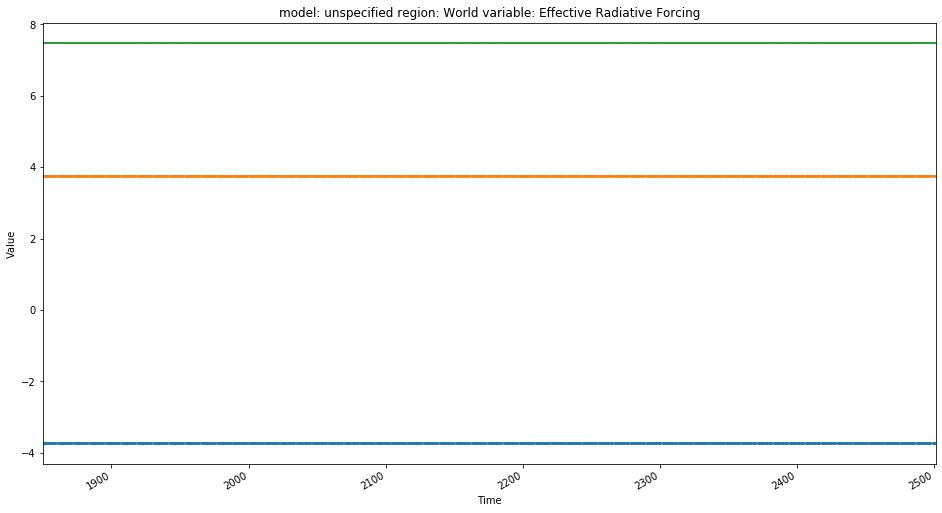

In [109]:
ax = results.filter(scenario="abrupt-*").filter(variable="*Forcing").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)

(-4, 15)

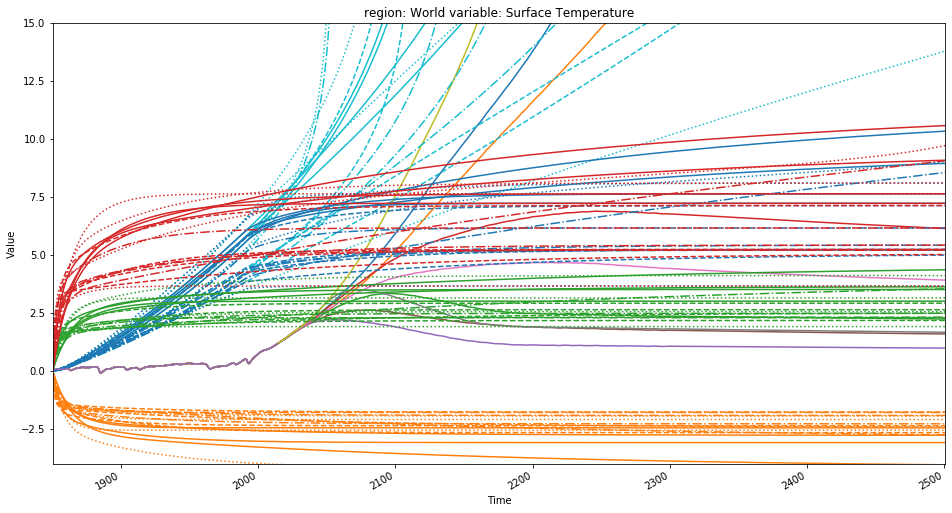

In [110]:
ax = results.filter(scenario=["piControl"], keep=False).filter(variable="Surface Temperature").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)
ax.set_ylim([-4, 15])

(-4, 15)

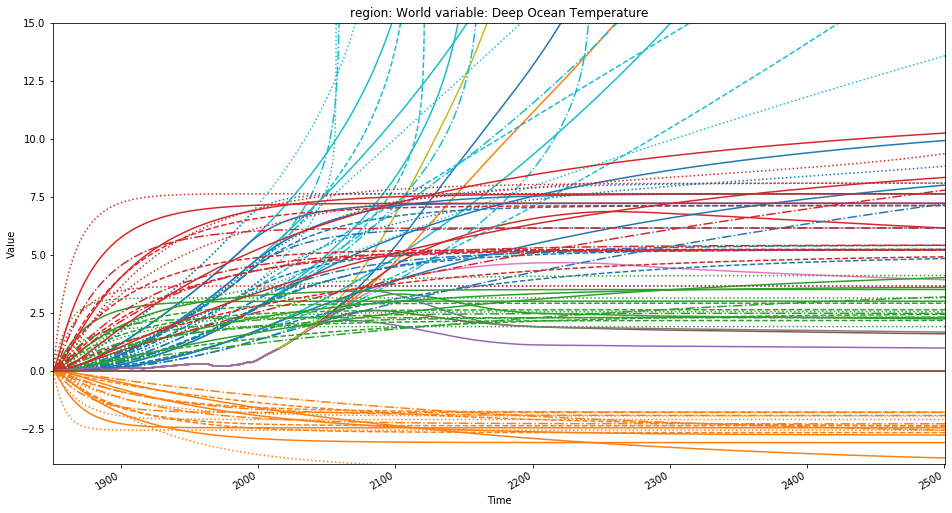

In [111]:
ax = results.filter(variable="Deep Ocean Temperature").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)
ax.set_ylim([-4, 15])

In [112]:
results_out = results.time_mean("AC")
results_out.tail()

time                                                                                         1850-07-01 00:00:00  \
model         scenario       region variable     unit    ECS (K)  climatemodel                                     
AIM/CGE       ssp370-lowNTCF World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.396066   
GCAM4         ssp434         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.396066   
              ssp460         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.396066   
REMIND-MAGPIE ssp534-over    World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.396066   
              ssp585         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.396066   

time                                                                                         1851-07-01 00:00:00  \
model         scenario       region variable     unit    ECS (K)  climatemodel                                     
AIM/CGE       ssp370-lowNTCF World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.394524   
GCAM4         ssp434         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.394524   
              ssp460         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.394524   
REMIND-MAGPIE ssp534-over    World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.394524   
              ssp585         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.394524   

time                                                                                         1852-07-01 00:00:00  \
model         scenario       region variable     unit    ECS (K)  climatemodel                                     
AIM/CGE       ssp370-lowNTCF World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.393673   
GCAM4         ssp434         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.393673   
              ssp460         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.393673   
REMIND-MAGPIE ssp534-over    World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.393673   
              ssp585         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.393673   

time                                                                                         1853-07-01 00:00:00  \
model         scenario       region variable     unit    ECS (K)  climatemodel                                     
AIM/CGE       ssp370-lowNTCF World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.393809   
GCAM4         ssp434         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.393809   
              ssp460         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.393809   
REMIND-MAGPIE ssp534-over    World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.393809   
              ssp585         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.393809   

time                                                                                         1854-07-01 00:00:00  \
model         scenario       region variable     unit    ECS (K)  climatemodel                                     
AIM/CGE       ssp370-lowNTCF World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.394109   
GCAM4         ssp434         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.394109   
              ssp460         World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.394109   
REMIND-MAGPIE ssp534-over    World  lambda_model W/m^2/K 2.999088 held-two-layer-uom-ECS-3K            -1.394109   
              ssp585         World  lambda_model W/m

INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


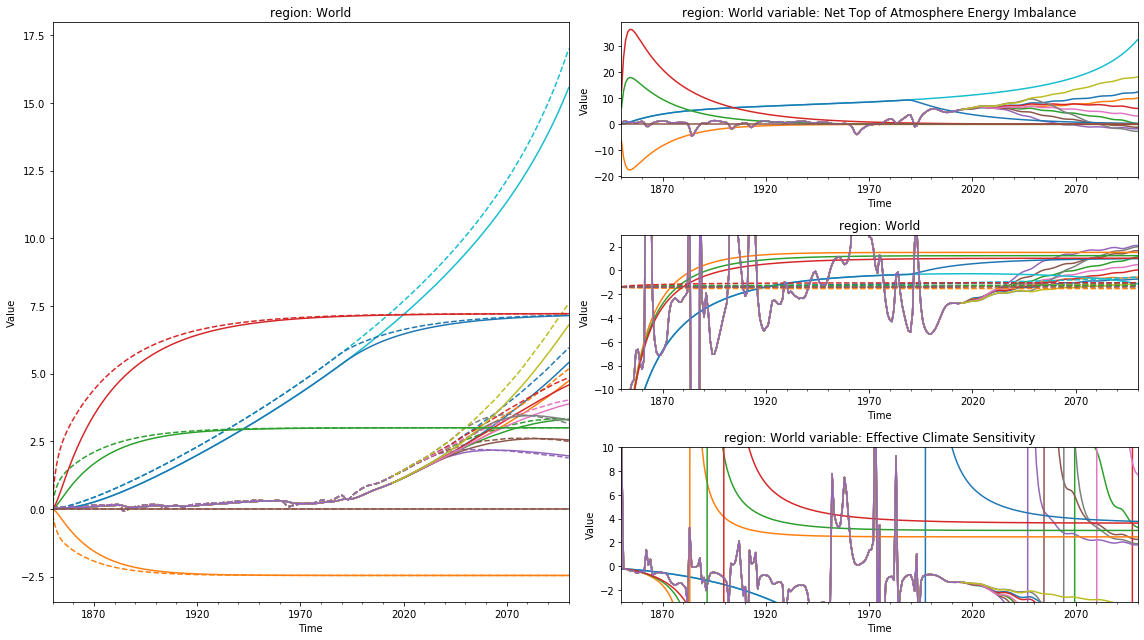

In [124]:
cfg = "BCC-CSM2-MR"
cfg = "UKESM1-0-LL"
cfg = "ECS-3K"
years = range(1850, 2101)
colour_by = "scenario"
linestyle_by = "variable"

pdf = results_out.filter(
    year=years,
    climatemodel="*{}*".format(cfg)
)

fig = plt.figure(figsize=(16, 9))
spec2 = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec2[:, 0])
ax2 = fig.add_subplot(spec2[0, 1])
ax3 = fig.add_subplot(spec2[1, 1])
ax4 = fig.add_subplot(spec2[2, 1])

pdf.filter(
    variable=["Surface Temperature", "Deep Ocean Temperature"]
).line_plot(ax=ax1, color=colour_by, linestyle=linestyle_by)
pdf.filter(
    variable=["Net Top of Atmosphere Energy Imbalance"]
).line_plot(ax=ax2, color=colour_by, linestyle=linestyle_by)
pdf.filter(
    variable=["Effective Climate Feedback", "lambda_model"]
).line_plot(ax=ax3, color=colour_by, linestyle=linestyle_by)
ax3.set_ylim([-10, 3])

pdf.filter(
    variable=["Effective Climate Sensitivity"]
).line_plot(ax=ax4, color=colour_by, linestyle=linestyle_by)
ax4.set_ylim([-3, 10])

plt.tight_layout()

In [114]:
results_out_with_tcr = []
for cm in results_out["climatemodel"].unique():
    tcr = results_out.filter(
        climatemodel=cm, 
        variable="Surface Temperature", 
        scenario="1pctCO2", 
        year=1920,
    )
    
    tmp = results_out.filter(climatemodel=cm)
    tmp.set_meta(tcr.values.squeeze(), "TCR (K)")
    
    results_out_with_tcr.append(tmp)
    
results_out_with_tcr = df_append(results_out_with_tcr)
results_out_with_tcr.filter(
    scenario="1pctCO2", variable="Surface Temperature"
).timeseries()

time                                                                                                                       1850-07-01 00:00:00  \
model       scenario region variable            unit ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Surface Temperature K    4.153464 1.658437 held-two-layer-uom-CMIP6-NorCPM1_r1i1p1f1-CALIB                0.000553   
                                                     2.168189 1.721965 held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f1...             0.000992   
                                                     1.902927 1.737073 held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-C...             0.001502   
                                                     2.312989 1.751368 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB               0.000660   
                                                     2.503380 1.764461 held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-C...             0.001479   
                                                     2.477079 1.898762 held-two-layer-uom-CMIP6-GISS-E2-1-H_r1i1p1f1-C...             0.000832   
                                                     2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.002120   
                                                     2.286604 1.987848 held-two-layer-uom-CMIP6-CNRM-ESM2-1_r1i1p1f2-C...             0.001372   
                                                     2.550936 2.017488 held-two-layer-uom-CMIP6-CESM2-WACCM_r1i1p1f1-C...             0.001823   
                                                     3.633154 2.154501 held-two-layer-uom-CMIP6-CESM2_r1i1p1f1-CALIB                  0.000395   
                                                     2.999088 2.291569 held-two-layer-uom-ECS-3K                                      0.001010   
                                                     2.912737 2.322366 held-two-layer-uom-CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB             0.001173   
                                                     4.569179 2.395252 held-two-layer-uom-CMIP6-IPSL-CM6A-LR_r1i1p1f1-...             0.000389   
                                                     3.503704 2.498671 held-two-layer-uom-CMIP6-EC-Earth3-Veg_r1i1p1f1...             0.000785   
                                                     3.138895 2.654635 held-two-layer-uom-CMIP6-CanESM5_r1i1p1f1-CALIB                0.000951   
                                                     4.106010 2.826522 held-two-layer-uom-CMIP6-UKESM1-0-LL_r1i1p1f2-C...             0.000723   

time                                                                                                                       1851-07-01 00:00:00  \
model       scenario region variable            unit ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Surface Temperature K    4.153464 1.658437 held-two-layer-uom-CMIP6-NorCPM1_r1i1p1f1-CALIB                0.003976   
                                                     2.168189 1.721965 held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f1...             0.006825   
                                                     1.902927 1.737073 held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-C...             0.009697   
                                                     2.312989 1.751368 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB               0.004703   
                                                     2.503380 1.764461 held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-C...             0.009833   
                                                     2.477079 1.898762 held-two-layer-uom-CMIP6-GISS-E2-1-H_r1i1p1f1-C...             0.005870   
                                                     2.631654 1.968482 held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-C...             0.013104   
                                                     2.28

In [115]:
results_out_with_tcr["variable"].unique()

array(['Deep Ocean Temperature', 'Effective Climate Feedback',
       'Effective Climate Sensitivity', 'Effective Radiative Forcing',
       'Net Top of Atmosphere Energy Imbalance', 'Surface Temperature',
       'lambda_model'], dtype=object)

In [116]:
save_scmdf = results_out_with_tcr.filter(
    variable=["lambda_model", "Deep Ocean Temperature"], keep=False
).timeseries()
save_scmdf.head()

time                                                                                                                                 1850-07-01 00:00:00  \
model       scenario region variable                   unit    ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Effective Climate Feedback W/m^2/K 4.153464 1.658437 held-two-layer-uom-CMIP6-NorCPM1_r1i1p1f1-CALIB                     inf   
                                                               2.168189 1.721965 held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f1...                  inf   
                                                               1.902927 1.737073 held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-C...                  inf   
                                                               2.312989 1.751368 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB                    inf   
                                                               2.503380 1.764461 held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-C...                  inf   

time                                                                                                                                 1851-07-01 00:00:00  \
model       scenario region variable                   unit    ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Effective Climate Feedback W/m^2/K 4.153464 1.658437 held-two-layer-uom-CMIP6-NorCPM1_r1i1p1f1-CALIB                2.290913   
                                                               2.168189 1.721965 held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f1...             1.772341   
                                                               1.902927 1.737073 held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-C...            -7.541992   
                                                               2.312989 1.751368 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB              -1.716249   
                                                               2.503380 1.764461 held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-C...             1.381342   

time                                                                                                                                 1852-07-01 00:00:00  \
model       scenario region variable                   unit    ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Effective Climate Feedback W/m^2/K 4.153464 1.658437 held-two-layer-uom-CMIP6-NorCPM1_r1i1p1f1-CALIB                1.466638   
                                                               2.168189 1.721965 held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f1...             1.340662   
                                                               1.902927 1.737073 held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-C...            -7.984747   
                                                               2.312989 1.751368 held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB              -2.587806   
                                                               2.503380 1.764461 held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-C...             1.098969   

time                                                                                                                                 1853-07-01 00:00:00  \
model       scenario region variable                   unit    ECS (K)  TCR (K)  climatemodel                                                              
unspecified 1pctCO2  World  Effective Climate Feedback W/m^2/K 4.153464 1.658437 held-two-layer-uom-CMIP6-NorCPM1_r1i1p1f1-CALIB                1.275754   
                                                               2.168189 1.721965 held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f1...             1.245013   
                                                               1.902927 1.737073 held-two-layer-u

Convert TOA energy imbalance to joules per year.

In [117]:
# area of earth ~ 5.1 * 10^14 m2
# seconds per year ~ 365.25 * 24 * 60 * 60 = 31,557,600
# 1 W/m2 = 1 * 5.1 * 10^14 m2 * 3.1557600 * 10 ** 7 = 5.101 * 3.15576 * 10**21
wm2_to_zetajoule = 5.101 * 3.15576
save_scmdf[
    save_scmdf.index.get_level_values("variable") == "Net Top of Atmosphere Energy Imbalance"
] *= wm2_to_zetajoule

save_scmdf = save_scmdf.reset_index()
save_scmdf.loc[
    save_scmdf["variable"] == "Net Top of Atmosphere Energy Imbalance",
    "unit"
] = "ZJ/yr"
save_scmdf.head()

time,model,scenario,region,variable,unit,ECS (K),TCR (K),climatemodel,1850-07-01 00:00:00,1851-07-01 00:00:00,...,2491-07-01 00:00:00,2492-07-01 00:00:00,2493-07-01 00:00:00,2494-07-01 00:00:00,2495-07-01 00:00:00,2496-07-01 00:00:00,2497-07-01 00:00:00,2498-07-01 00:00:00,2499-07-01 00:00:00,2500-07-01 00:00:00
0,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,4.153464,1.658437,held-two-layer-uom-CMIP6-NorCPM1_r1i1p1f1-CALIB,inf,2.290913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,2.168189,1.721965,held-two-layer-uom-CMIP6-MPI-ESM1-2-HR_r1i1p1f...,inf,1.772341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,1.902927,1.737073,held-two-layer-uom-CMIP6-GISS-E2-2-G_r1i1p1f1-...,inf,-7.541992,...,2.345299,2.346382,2.347466,2.348553,2.349636,2.350714,2.351793,2.352874,2.353952,2.355028
3,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,2.312989,1.751368,held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB,inf,-1.716249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,unspecified,1pctCO2,World,Effective Climate Feedback,W/m^2/K,2.503380,1.764461,held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-...,inf,1.381342,...,1.247175,1.247059,1.246942,1.246825,1.246707,1.246589,1.246470,1.246350,1.246230,1.246110


In [118]:
def rename_vars(inv):
    if inv == "Surface Temperature":
        return "Surface Air Temperature Change"
    
    if inv == "Net Top of Atmosphere Energy Imbalance":
        return "Heat Uptake"
    return inv

save_scmdf["variable"] = save_scmdf["variable"].apply(rename_vars)
save_scmdf = ScmDataFrame(save_scmdf)
save_scmdf = save_scmdf.timeseries()
save_scmdf.columns = save_scmdf.columns.map(lambda x: x.year)
save_scmdf = pyam.IamDataFrame(save_scmdf)
save_scmdf.to_csv("held-two-layer-rcmip-phase-1-results.csv")

In [119]:
save_scmdf["variable"].unique()

array(['Effective Climate Feedback', 'Effective Climate Sensitivity',
       'Effective Radiative Forcing', 'Heat Uptake',
       'Surface Air Temperature Change'], dtype=object)

In [120]:
save_scmdf.head(5)

,model,scenario,region,variable,unit,year,climatemodel,ecs (k),tcr (k),value
0,AIM/CGE,ssp370,World,Effective Climate Feedback,W/m^2/K,1850,held-two-layer-uom-ECS-3K,2.999088,2.291569,inf
1,AIM/CGE,ssp370,World,Effective Climate Feedback,W/m^2/K,1851,held-two-layer-uom-ECS-3K,2.999088,2.291569,-15.881931
2,AIM/CGE,ssp370,World,Effective Climate Feedback,W/m^2/K,1852,held-two-layer-uom-ECS-3K,2.999088,2.291569,-15.116112
3,AIM/CGE,ssp370,World,Effective Climate Feedback,W/m^2/K,1853,held-two-layer-uom-ECS-3K,2.999088,2.291569,-13.021856
4,AIM/CGE,ssp370,World,Effective Climate Feedback,W/m^2/K,1854,held-two-layer-uom-ECS-3K,2.999088,2.291569,-10.225040


In [121]:
desc = save_scmdf[["climatemodel", "ecs (k)", "tcr (k)"]].drop_duplicates()
desc["name"] = desc["climatemodel"].apply(lambda x: x[:14])
desc["version"] = desc["climatemodel"].apply(lambda x: x[15:18])
desc["config"] = desc["climatemodel"].apply(lambda x: "-".join(x.split("-")[4:]))

desc.to_csv("held-two-layer-rcmip-model-desc.csv")
desc

,climatemodel,ecs (k),tcr (k),name,version,config
0,held-two-layer-uom-ECS-3K,2.999088,2.291569,held-two-layer,uom,ECS-3K
26689,held-two-layer-uom-CMIP6-BCC-CSM2-MR_r1i1p1f1-...,2.631654,1.968482,held-two-layer,uom,CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB
26690,held-two-layer-uom-CMIP6-BCC-ESM1_r1i1p1f1-CALIB,2.312989,1.751368,held-two-layer,uom,CMIP6-BCC-ESM1_r1i1p1f1-CALIB
26691,held-two-layer-uom-CMIP6-CESM2-WACCM_r1i1p1f1-...,2.550936,2.017488,held-two-layer,uom,CMIP6-CESM2-WACCM_r1i1p1f1-CALIB
26692,held-two-layer-uom-CMIP6-CESM2_r1i1p1f1-CALIB,3.633154,2.154501,held-two-layer,uom,CMIP6-CESM2_r1i1p1f1-CALIB
26693,held-two-layer-uom-CMIP6-CNRM-CM6-1_r1i1p1f2-C...,2.912737,2.322366,held-two-layer,uom,CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB
26694,held-two-layer-uom-CMIP6-CNRM-ESM2-1_r1i1p1f2-...,2.286604,1.987848,held-two-layer,uom,CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB
26695,held-two-layer-uom-CMIP6-CanESM5_r1i1p1f1-CALIB,3.138895,2.654635,held-two-layer,uom,CMIP6-CanESM5_r1i1p1f1-CALIB
26696,held-two-layer-uom-CMIP6-EC-Earth3-Veg_r1i1p1f...,3.503704,2.498671,held-two-layer,uom,CMIP6-EC-Earth3-Veg_r1i1p1f1-CALIB
26697,held-two-layer-uom-CMIP6-GISS-E2-1-G_r1i1p1f1-...,2.503380,1.764461,held-two-layer,uom,CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB
